# MuJoCo basics

We begin by defining and loading a simple model:

In [19]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time
import itertools
import numpy as np

In [20]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

The `xml` string is written in MuJoCo's [MJCF](http://www.mujoco.org/book/modeling.html), which is an [XML](https://en.wikipedia.org/wiki/XML#Key_terminology)-based modeling language.
  - The only required element is `<mujoco>`. The smallest valid MJCF model is `<mujoco/>` which is a completely empty model.
  - All physical elements live inside the `<worldbody>` which is always the top-level body and constitutes the global origin in Cartesian coordinates.
  - We define two geoms in the world named `red_box` and `green_sphere`.
  - **Question:** The `red_box` has no position, the `green_sphere` has no type, why is that?
    - **Answer:** MJCF attributes have *default values*. The default position is `0 0 0`, the default geom type is `sphere`. The MJCF language is described in the documentation's [XML Reference chapter](https://mujoco.readthedocs.io/en/latest/XMLreference.html).

The `from_xml_string()` method invokes the model compiler, which creates a binary `mjModel` instance.

## mjModel

MuJoCo's `mjModel`, contains the *model description*, i.e., all quantities which *do not change over time*. The complete description of `mjModel` can be found at the end of the header file [`mjmodel.h`](https://github.com/deepmind/mujoco/blob/main/include/mujoco/mjmodel.h). Note that the header files contain short, useful inline comments, describing each field.

Examples of quantities that can be found in `mjModel` are `ngeom`, the number of geoms in the scene and `geom_rgba`, their respective colors:

In [21]:
model.ngeom

2

In [22]:
model.geom_rgba

array([[1., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

## Named access

The MuJoCo Python bindings provide convenient [accessors](https://mujoco.readthedocs.io/en/latest/python.html#named-access) using names. Calling the `model.geom()` accessor without a name string generates a convenient error that tells us what the valid names are.

In [23]:
try:
  model.geom()
except KeyError as e:
  print(e)

"Invalid name ''. Valid names: ['green_sphere', 'red_box']"


Calling the named accessor without specifying a property will tell us what all the valid properties are:

In [24]:
model.geom('green_sphere')

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>

Let's read the `green_sphere`'s rgba values:

In [25]:
model.geom('green_sphere').rgba

array([0., 1., 0., 1.], dtype=float32)

This functionality is a convenience shortcut for MuJoCo's [`mj_name2id`](https://mujoco.readthedocs.io/en/latest/APIreference.html?highlight=mj_name2id#mj-name2id) function:

In [26]:
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

array([0., 1., 0., 1.], dtype=float32)

Similarly, the read-only `id` and `name` properties can be used to convert from id to name and back:

In [27]:
print('id of "green_sphere": ', model.geom('green_sphere').id)
print('name of geom 1: ', model.geom(1).name)
print('name of body 0: ', model.body(0).name)

id of "green_sphere":  1
name of geom 1:  green_sphere
name of body 0:  world


Note that the 0th body is always the `world`. It cannot be renamed.

The `id` and `name` attributes are useful in Python comprehensions:

In [28]:
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

## `mjData`
`mjData` contains the *state* and quantities that depend on it. The state is made up of time, [generalized](https://en.wikipedia.org/wiki/Generalized_coordinates) positions and generalized velocities. These are respectively `data.time`, `data.qpos` and `data.qvel`. In order to make a new `mjData`, all we need is our `mjModel`

In [29]:
data = mujoco.MjData(model)

`mjData` also contains *functions of the state*, for example the Cartesian positions of objects in the world frame. The (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [30]:
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


Wait, why are both of our geoms at the origin? Didn't we offset the green sphere? The answer is that derived quantities in `mjData` need to be explicitly propagated (see [below](#scrollTo=QY1gpms1HXeN)). In our case, the minimal required function is [`mj_kinematics`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-kinematics), which computes global Cartesian poses for all objects (excluding cameras and lights).

In [31]:
mujoco.mj_kinematics(model, data)
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

raw access:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]

named access:
 [0.2 0.2 0.2]


# Basic rendering, simulation, and animation

In order to render we'll need to instantiate a `Renderer` object and call its `render` method.

We'll also reload our model to make the colab's sections independent.

""

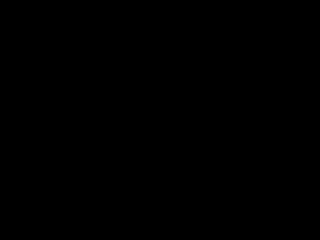

In [32]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
#
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
media.show_image(renderer.render())

Hmmm, why the black pixels?

**Answer:** For the same reason as above, we first need to propagate the values in `mjData`. This time we'll call [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-forward), which invokes the entire pipeline up to the computation of accelerations i.e., it computes $\dot x = f(x)$, where $x$ is the state. This function does more than we actually need, but unless we care about saving computation time, it's good practice to call `mj_forward` since then we know we are not missing anything.

We also need to update the `mjvScene` which is an object held by the renderer describing the visual scene. We'll later see that the scene can include visual objects which are not part of the physical model.

""

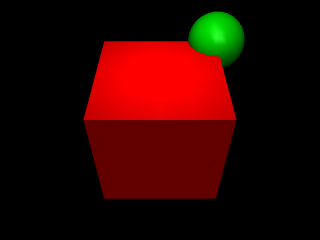

In [16]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

# Simulation

Now let's simulate and make a video. We'll use MuJoCo's main high level function `mj_step`, which steps the state $x_{t+h} = f(x_t)$.

Note that in the code block below we are *not* rendering after each call to `mj_step`. This is because the default timestep is 2ms, and we want a 60fps video, not 500fps.

In [17]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

But isn't anything moving?